# Notes : Chapter-3 | Looking inside Large Language Models

## An Overview of Transformer Models
### The Input and Outputs of a Trained Transformer LLM
- At a high level of abstraction, Transformer LLMs take a text prompt and
output generated text.
- Transformer LLMs generate one token at a time, not the entire text at once. Each token generation step is one forward pass through the model.
- An output token is appended to the prompt, then this new text is presented to the model again for another forward pass to generate the next token.
- There’s a specific word used in machine learning to describe models that consume their earlier predictions to make later predictions (e.g., the model’s first generated token is used to generate the second token). They’re called autoregressive models. That is why you’ll hear text generation LLMs being called autoregressive models. This is often used to differentiate text generation models from text representation models
like BERT, which are not autoregressive.
- This autoregressive, token-by-token generation is what happens under the hood when we generate text with the LLMs.

### The Components of Forward Pass
- In addition to the loop, two key internal components are the tokenizer and the language modeling head (LM head).
- The tokenizer is followed by the neural network: a stack of Transformer blocks that do all of the processing.
- That stack is then followed by the LM head, which translates the output of the stack into probability scores for what the most likely next token is.
- A Transformer LLM is made up of a tokenizer, a stack of Transformer blocks, and a language modeling head.
- the tokenizer contains a table of tokens—the tokenizer’s
vocabulary.
- The model has a vector representation associated with each of these
tokens in the vocabulary (token embeddings).
- For each generated token, the process flows once through each of the Transformer blocks in the stack in order, then to the LM head, which finally outputs the probability distribution for the next token.
- At the end of the forward pass, the model predicts a probability score for each token in the vocabulary.
- The LM head is a simple neural network layer itself. It is one of multiple possible “heads” to attach to a stack of Transformer blocks to build different kinds of systems. Other kinds of Transformer heads include sequence classification heads and token classification heads.

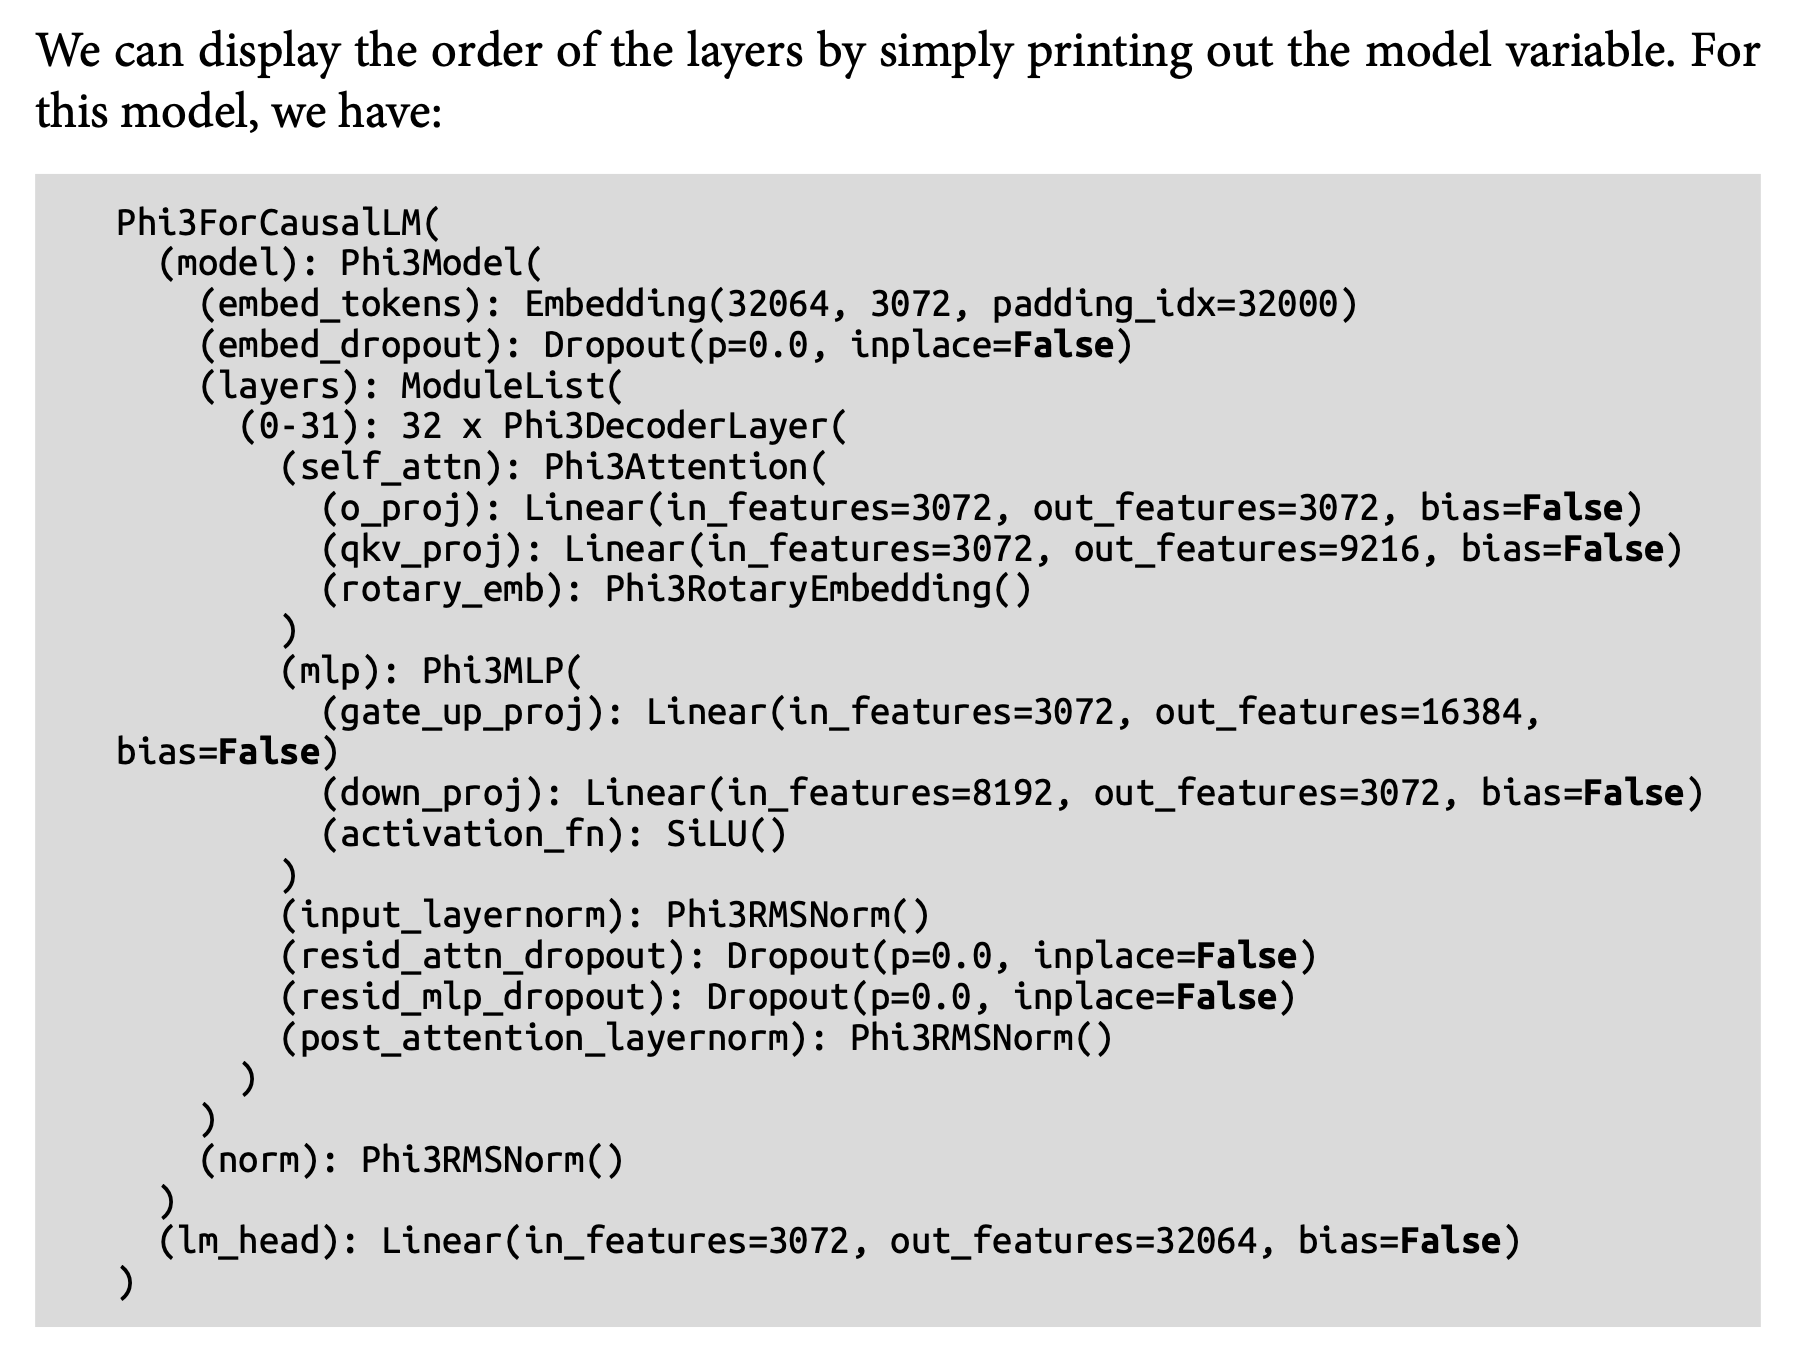
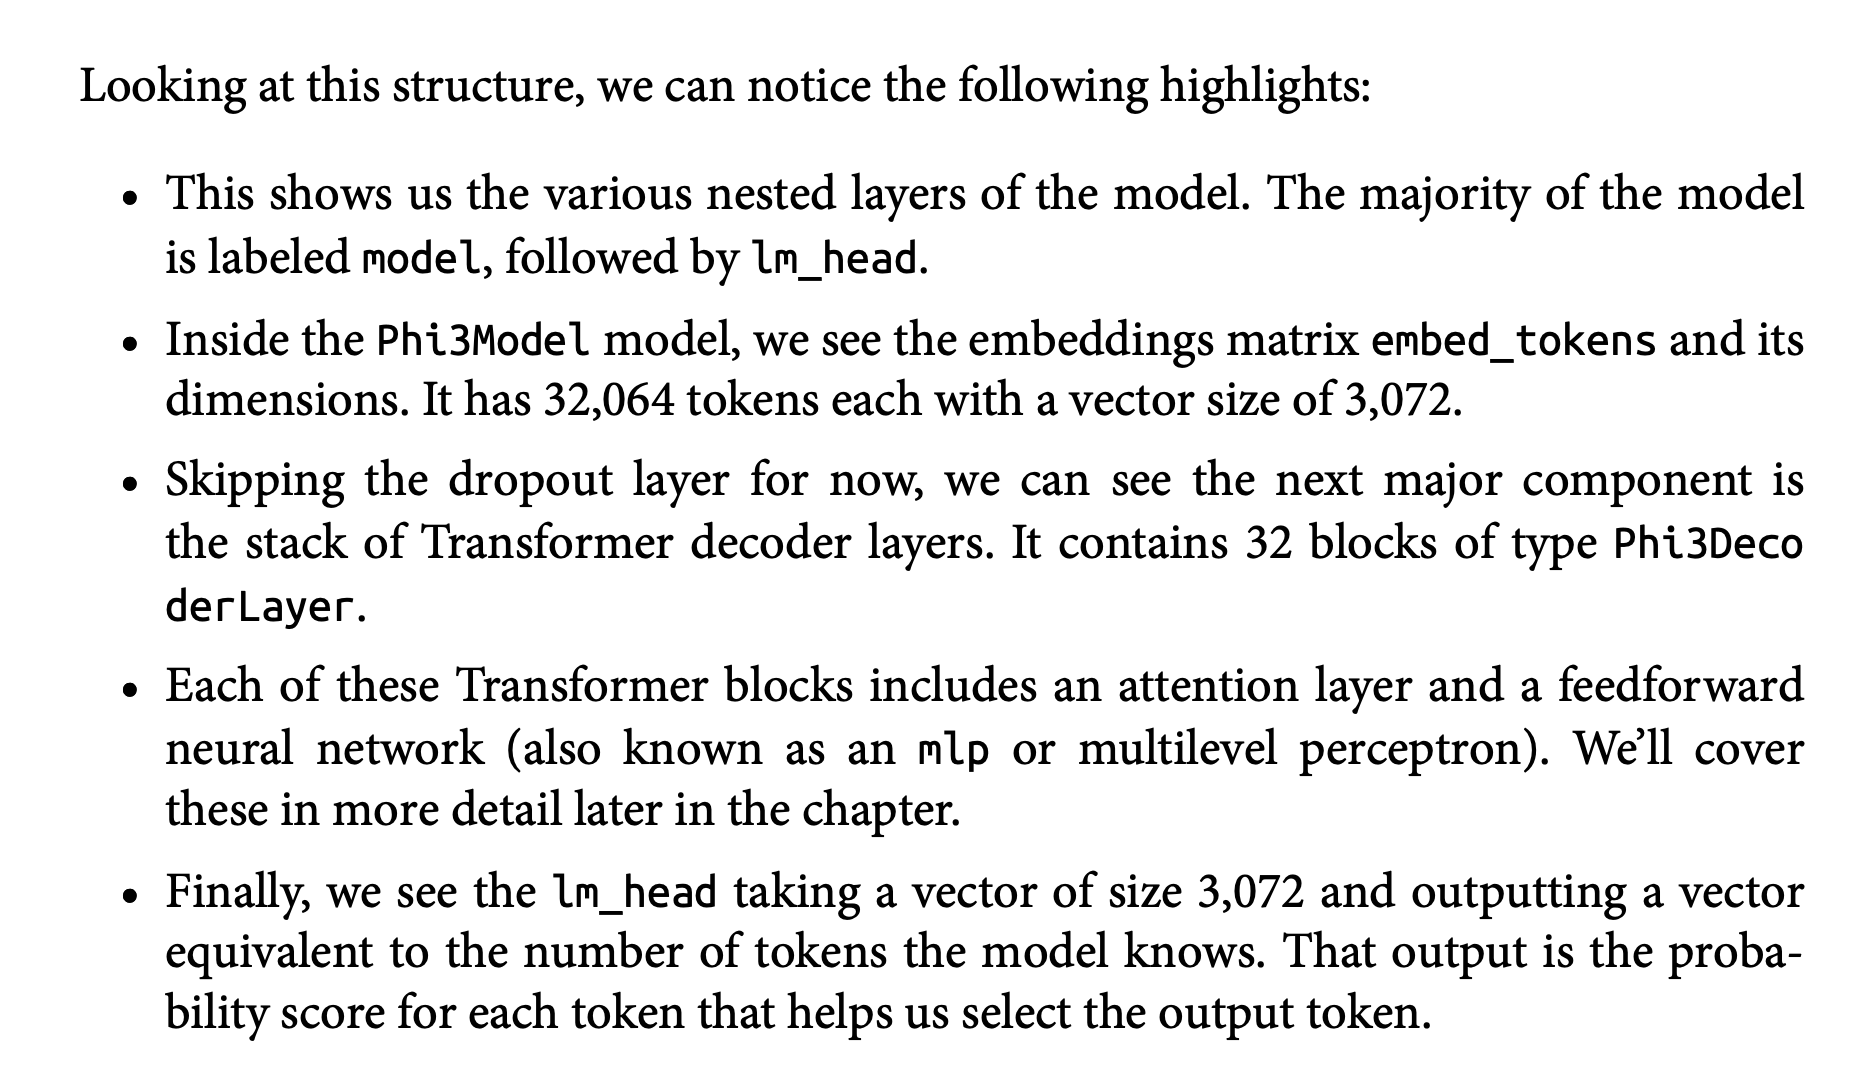

### Choosing a single token from the porbability distribution (sampling/ decoding)
- The method of choosing a single token from the probability distribution is called the decoding strategy.
- The easiest decoding strategy would be to always pick the token with the highest probability score. In practice, this doesn’t tend to lead to the best outputs for most use cases. A better approach is to add some randomness and sometimes choose the second or third highest probability token. The idea here is to basically sample from the probability distribution based on the probability score, as the statisticians would say.
- Choosing the highest scoring token every time is called greedy decoding. It’s what happens if you set the temperature parameter to zero in an LLM.

### Parallel Token Processing and Context Size
- Each token is processed through its own stream of computation (with some interaction between them in attention steps, as we’ll later see).
- Current Transformer models have a limit for how many tokens they can process at once. That limit is called the model’s context length. A model with 4K context length can only process 4K tokens and would only have 4K of these streams.
- Each processing stream takes a vector as input and produces a final resulting vector of the same size (often referred to as the model dimension).
- For text generation, only the output result of the last stream is used to predict the next token. That output vector is the only input into the LM head as it calculates the probabilities of the next token.

### Speeding Up Generations by Caching Keys and Values
- Recall that when generating the second token, we simply append the output token to the input and do another forward pass through the model. If we give the model the ability to cache the results of the previous calculation (especially some of the specific vectors in the attention mechanism), we no longer need to repeat the calculations of the previous streams. This time the only needed calculation is for the last stream.
- This is an optimization technique called the keys and values (kv) cache and it provides a significant speedup of the generation process. Keys and values are some of the central components of the attention mechanism.
- When generating text, it’s important to cache the computation results of previous tokens instead of repeating the same calculation over and over again

## Inside the Transformer Block
- The bulk of the Transformer LLM processing happens inside a series of
Transformer blocks, each handing the result of its processing as input to the subsequent block.
- A Transformer block (Figure 3-12) is made up of two successive components:
    1. The attention layer is mainly concerned with incorporating relevant information from other input tokens and positions
    2. The feedforward layer houses the majority of the model’s processing capacity

**Feedforward Neural Network**
- The feedforward neural network component of a Transformer block likely
does the majority of the model’s memorization and interpolation.
- raw language models (like GPT-3) are difficult for people to properly utilize. This is why the language model is then trained on instruction-tuning and human preference and feedback fine-tuning to match people’s expectations of what the model should output.

**Attention Layer at a glance**
- Attention is a mechanism that helps the model incorporate context as it’s processing a specific token.
- Attention adds information from the context into the representation of the tokens.
- The self-attention layer incorporates relevant information from previous positions that help process the current token.

**Attention is all you need**
- Attention is made up of two major steps: relevance scoring for each position, then a step where we combine the information based on those scores.
- We get better LLMs by doing attention multiple times in parallel, increasing the model’s capacity to attend to different types of information.
- The training process produces three projection matrices that produce the components that interact in this calculation:
    — A query projection matrix
    — A key projection matrix
    — A value projection matrix
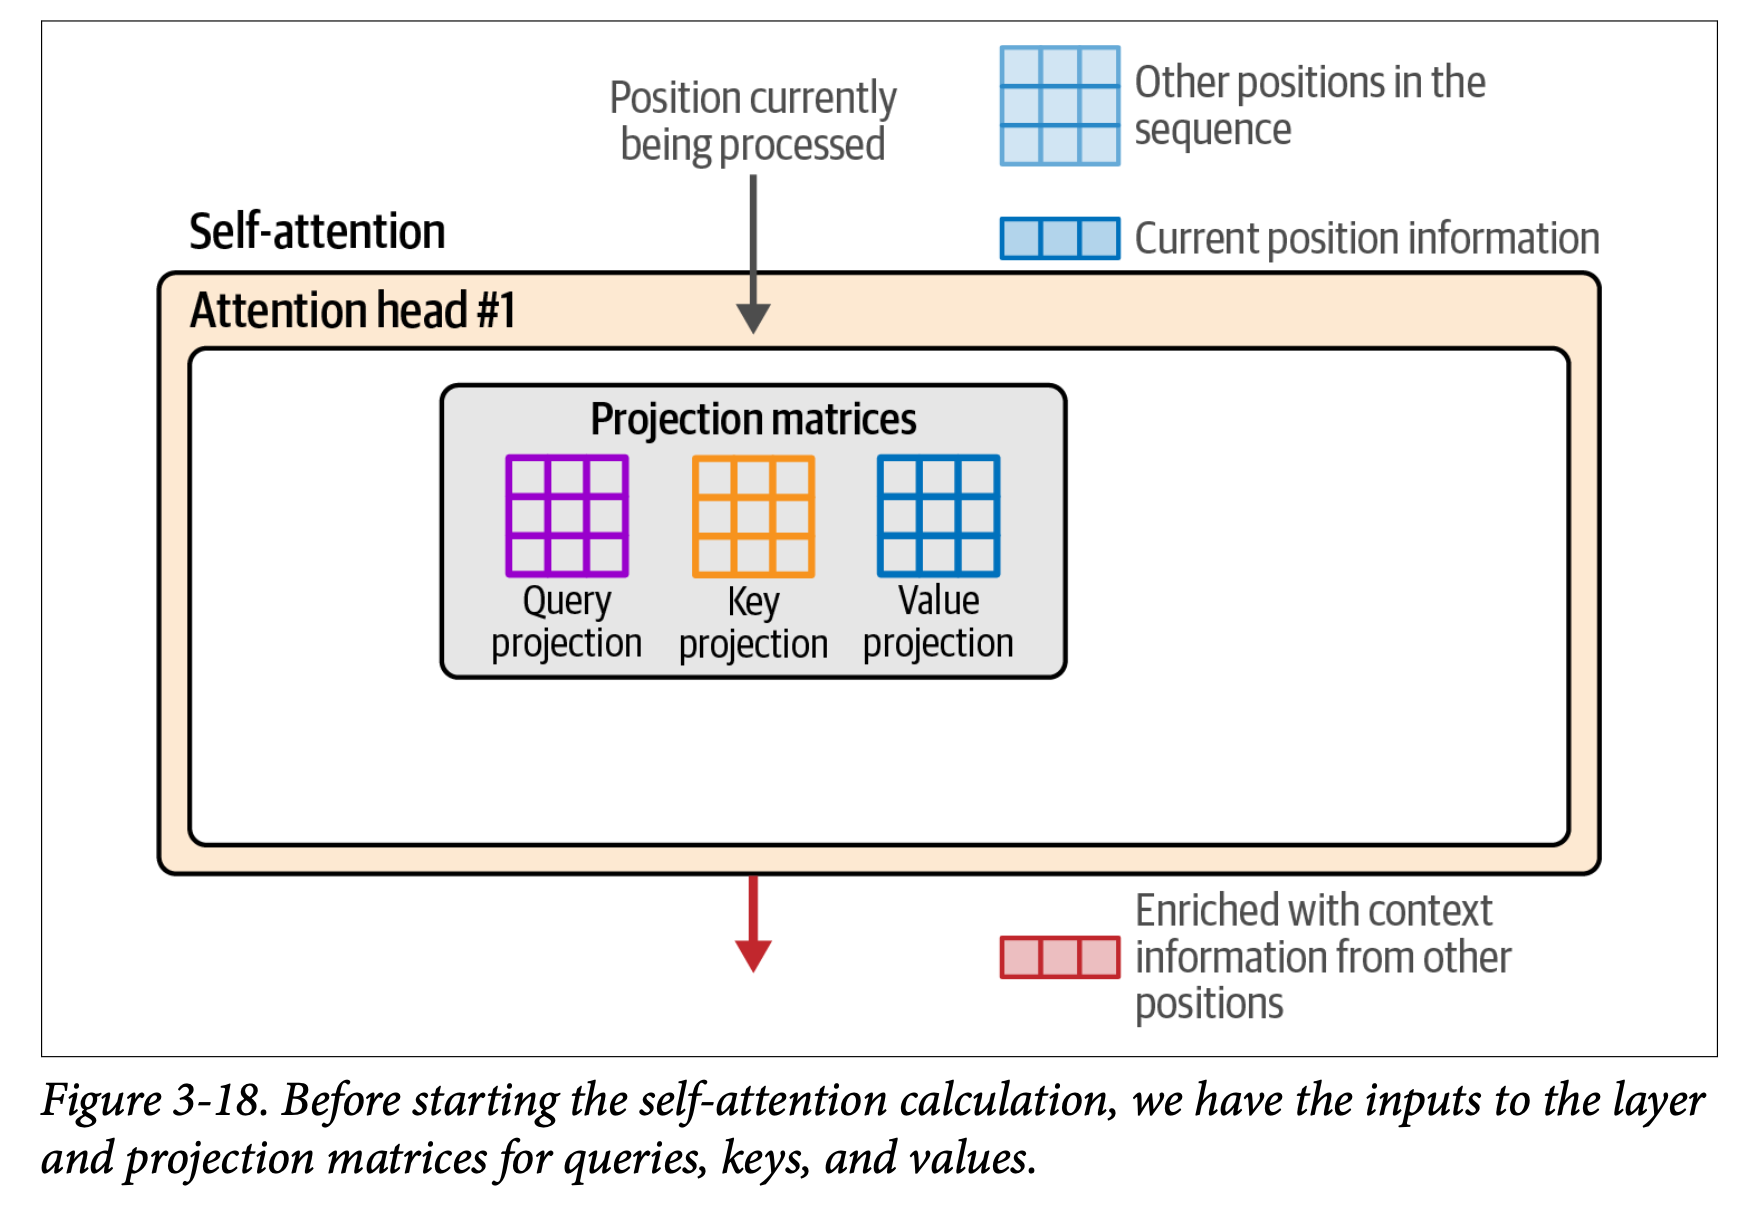


# Codes


Let’s start by loading a language model and getting it ready for generation by declaring a pipeline.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline


In [ ]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="mps",
    torch_dtype = "auto",
    trust_remote_code = True
)

In [ ]:
model

In [ ]:
# Create a pipeline
generator = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    return_full_text = False,
    max_new_tokens = 50,
    do_sample = False
)

In [ ]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

output = generator(prompt)

print(output[0]['generated_text'])

Let's look more closely at the code that demonstrates the process of greedy decoding strategy.

In [ ]:
prompt = "The Capital of France is"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors='pt').input_ids

# Tokenize the input prompt using the current device
input_ids = input_ids.to("mps")

# Get the output of the model before the lm_head
model_output = model.model(input_ids)
# print(model_output)

# Get the ouput of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [ ]:
token_id = lm_head_output[0,-1].argmax(-1)
tokenizer.decode(token_id)

In [ ]:
print(lm_head_output, "\n", lm_head_output.shape)

*Optimizing with Caching keys and values*.

In Hugging Face Transformers, cache is enabled by default. We can disable it by setting use_cache to `False`.

We can use the `%%timeit` magic command in Jupyter or Colab to time how long the execution takes (it runs the command several times and gets the average).

In fact, from a user experience standpoint, even the four-second generation time tends to be a long time to wait for a user that’s staring at a screen and waiting for an output from the model. This is one reason why LLM APIs stream the output tokens as the model generates them instead of waiting for the entire generation to be completed.

In [ ]:
prompt = "Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids = input_ids.to('mps')



In [ ]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
    input_ids = input_ids,
    max_new_tokens= 100,
    use_cache = True
)

In [ ]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
    input_ids = input_ids,
    max_new_tokens = 100,
    use_cache = False
)